In [19]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

class CachedSelectKBestMI(SelectKBest):
    def __init__(self, k, scores, score_func=mutual_info_classif):
        super().__init__(k=k, score_func=score_func)
        self.scores_ = scores
        self.scores = scores

    def fit(self, X, y):
        self._check_params(X, y)
        mask = np.zeros(len(self.scores_), dtype=bool)
        top_k_indices = np.argsort(self.scores_)[::-1][:self.k]
        mask[top_k_indices] = True
        self._mask = mask

        return self

In [5]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class CorrelationThreshold(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=1.0):
        self.threshold = threshold
        self.selected_features_ = None
        self.scores_ = None
        self.mask_ = None

    def fit(self, X, y=None):
        corr_matrix = np.abs(np.corrcoef(X, rowvar=False))
        self.scores_ = corr_matrix
        self.selected_features_ = np.arange(X.shape[1])
        keep_features = []
        for i in range(X.shape[1]):
            if i in self.selected_features_:
                keep_features.append(i)
                correlated_features = np.where(corr_matrix[i] > self.threshold)[0]
                self.selected_features_ = np.setdiff1d(self.selected_features_, correlated_features)
        self.selected_features_ = np.array(keep_features)
        mask = np.zeros(X.shape[1], dtype=bool)
        mask[self.selected_features_] = True
        self.mask_ = mask
        return self

    def transform(self, X):
        return X[:, self.selected_features_]

    def get_support(self):
        return self.mask_

In [1]:
import pandas as pd

train_data = pd.read_csv('../data/train.csv')

X_train, y_train = train_data.drop('Class', axis=1), train_data['Class']
X_train.shape, y_train.shape

((14409, 2400), (14409,))

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

vt = VarianceThreshold(threshold=0.1)
X_vt = vt.fit_transform(X_scaled)

mi = SelectKBest(score_func=mutual_info_classif, k=300)
mi.fit_transform(X_vt, y_train)
mi.scores_

array([0.03900862, 0.02403292, 0.31231443, ..., 0.24557222, 0.08479586,
       0.10673629])

In [11]:
np.save('../output/mutual_info.npy', mi.scores_)

In [21]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy.stats import randint, uniform

train_data = pd.read_csv('../data/train.csv')
valid_data = pd.read_csv('../data/valid.csv')
test_data = pd.read_csv('../data/test.csv')

X_train = train_data.drop('Class', axis=1)
y_train = train_data['Class']
X_valid = valid_data.drop('Class', axis=1)
y_valid = valid_data['Class']
X_test = test_data.drop('Class', axis=1)
y_test = test_data['Class']

# Combine train and validation sets for RandomizedSearchCV
X_combined = pd.concat([X_train, X_valid], axis=0)
y_combined = pd.concat([y_train, y_valid], axis=0)

# -1 for training samples, 0 for validation samples
split_index = [-1] * len(X_train) + [0] * len(X_valid)
cv = PredefinedSplit(test_fold=split_index)

# load mutual information scores
mi_scores = np.load('../output/mutual_info.npy')

In [81]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('vt', VarianceThreshold(threshold=0.1)),
    ('mi', CachedSelectKBestMI(scores=mi_scores, k=100)),
    ('ct', CorrelationThreshold(threshold=1.0)),
    ('clf', DecisionTreeClassifier()),
])

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted'),
    'roc_auc': make_scorer(roc_auc_score, average='weighted', multi_class='ovr'),
}

param_distributions = {
    'mi__k': list(range(100, 2500, 100)),
    'ct__threshold': [0.8, 0.7, 0.6, 0.5],
    'clf__max_depth': [3, 5, 10, 15, 20, None],
    'clf__min_samples_split': randint(2, 20),
    'clf__min_samples_leaf': randint(1, 10),
    'clf__max_features': [0.1, 0.3, 0.5, 0.7, 0.9],
    'clf__criterion': ['gini', 'entropy'],
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=50,
    cv=cv,
    scoring=scoring,
    refit='f1',
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

# Fit on combined data using the predefined split
random_search.fit(X_combined, y_combined)

# Print best parameters and validation scores
print("Best parameters:", random_search.best_params_)

Fitting 1 folds for each of 50 candidates, totalling 50 fits
Best parameters: {'clf__criterion': 'gini', 'clf__max_depth': 20, 'clf__max_features': 0.3, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 14, 'ct__threshold': 0.8, 'mi__k': 1500}


In [89]:
cv_results = pd.DataFrame(random_search.cv_results_)
results = cv_results[[
    'param_mi__k', 'param_ct__threshold', 'param_clf__max_depth',
    'param_clf__min_samples_split', 'param_clf__min_samples_leaf',
    'param_clf__max_features', 'param_clf__criterion',
    'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall',
    'mean_test_f1', 'mean_test_roc_auc',
    'rank_test_f1', 'rank_test_roc_auc', 'rank_test_accuracy',
]].sort_values(by=['mean_test_f1', 'mean_test_accuracy', 'mean_test_roc_auc'], ascending=False)
results

,param_mi__k,param_ct__threshold,param_clf__max_depth,param_clf__min_samples_split,param_clf__min_samples_leaf,param_clf__max_features,param_clf__criterion,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc,rank_test_f1,rank_test_roc_auc,rank_test_accuracy
12,1500,0.8,20,14,5,0.3,gini,0.999167,0.999168,0.999167,0.999167,0.999167,1,1,1
21,700,0.5,20,14,4,0.9,entropy,0.998751,0.998751,0.998751,0.998751,0.998751,2,2,2
2,600,0.7,None,13,2,0.9,gini,0.998543,0.998543,0.998543,0.998543,0.998543,3,5,3
32,1100,0.7,20,7,2,0.7,entropy,0.998543,0.998545,0.998543,0.998543,0.998543,4,4,3
34,1900,0.6,15,4,4,0.5,entropy,0.998543,0.998547,0.998543,0.998543,0.998543,5,3,3
47,1600,0.5,None,6,1,0.1,gini,0.998334,0.998337,0.998334,0.998334,0.998335,6,6,6
26,1700,0.5,15,10,6,0.5,entropy,0.998126,0.998130,0.998126,0.998126,0.998126,7,7,7
38,2300,0.5,None,6,5,0.7,entropy,0.997918,0.997918,0.997918,0.997918,0.997918,8,10,8
4,1600,0.5,15,11,1,0.1,gini,0.997918,0.997919,0.997918,0.997918,0.997918,9,9,8
41,300,0.7,None,17,3,0.7,entropy,0.997918,0.997927,0.997918,0.997918,0.997918,10,8,8


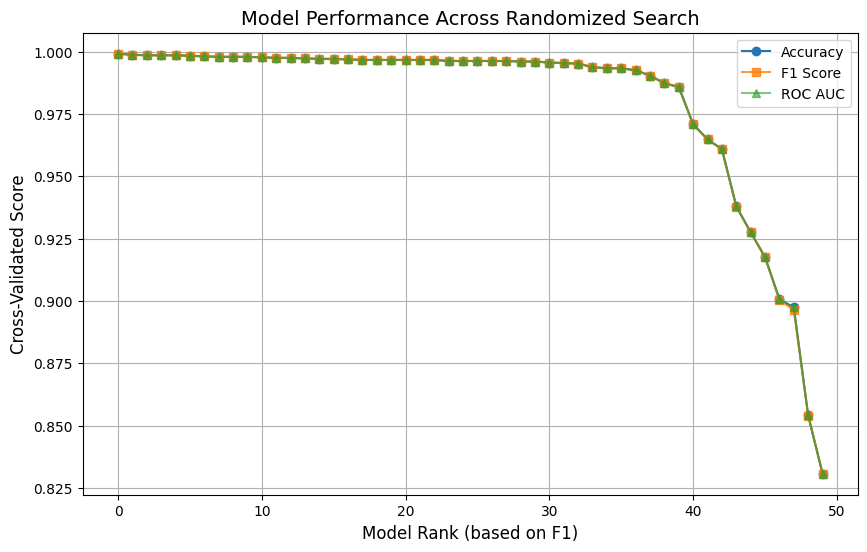

In [105]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# Plot Accuracy, F1, and ROC_AUC
plt.plot(results['mean_test_accuracy'].to_numpy(), label='Accuracy', marker='o', alpha=1.0)
plt.plot(results['mean_test_f1'].to_numpy(), label='F1 Score', marker='s', alpha=0.8)
plt.plot(results['mean_test_roc_auc'].to_numpy(), label='ROC AUC', marker='^', alpha=0.6)

plt.title('Model Performance Across Randomized Search', fontsize=14)
plt.xlabel('Model Rank (based on F1)', fontsize=12)
plt.ylabel('Cross-Validated Score', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [98]:
# Evaluate the best model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Best params:\n{random_search.best_params_}")

print("\nTest set scores:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.6f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.6f}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.6f}")
print(f"F1: {f1_score(y_test, y_pred, average='weighted'):.6f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred, average='weighted', multi_class='ovr'):.6f}")

Best params:
{'clf__criterion': 'gini', 'clf__max_depth': 20, 'clf__max_features': 0.3, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 14, 'ct__threshold': 0.8, 'mi__k': 1500}

Test set scores:
Accuracy: 0.998751
Precision: 0.998752
Recall: 0.998751
F1: 0.998751
ROC-AUC: 0.998751


In [ ]:
import joblib

joblib.dump(random_search.best_estimator_, '../output/models/decision_tree.pkl')
# model = joblib.load('best_model.pkl')